# Introduction

* This is a kaggle competition to predict the meter usage of a building.
* Link for the kaggle competition: https://www.kaggle.com/competitions/ashrae-energy-prediction/data?select=sample_submission.csv

### More about the meter property

In the ASHRAE - Great Energy Predictor III Kaggle competition, there were four types of energy meter used to measure energy consumption in buildings:

1. **Electricity Meter**: This meter measures the amount of electricity consumed by a building. It is typically installed at the main electrical panel or switchboard and records the total amount of energy consumed by the building.

2. **Chilled Water Meter**: This meter measures the amount of chilled water used by a building's cooling system. Chilled water is used to cool the air in a building and is circulated through a system of pipes and coils.

3. **Steam Meter**: This meter measures the amount of steam used by a building's heating system. Steam is used to heat the air in a building and is circulated through a system of pipes and radiators.

4. **Hot Water Meter**: This meter measures the amount of hot water used by a building. Hot water is used for a variety of purposes in a building, including heating, washing, and cooking.

### Evaluation Metric
The evaluation metric for this competition is Root Mean Squared Logarithmic Error
$$\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We will first work with our train datasets, creating and training a model and then move on to the test datasets predicting the outputs.

# Working with datasets

In [2]:
# This is a method to reduce memory usage of imported data. The idea is based on: https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage/notebook

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file, format_time):
    """create a dataframe and optimize its memory usage"""
#     df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = pd.read_csv(file)
    df = reduce_mem_usage(df)
    if (format_time):
        df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%d %H:%M:%S')
    return df

### Importing datasets

In [3]:
train = import_data("../input/ashrae-energy-prediction/train.csv", format_time=True)
test = import_data("../input/ashrae-energy-prediction/test.csv", format_time=True)
building_data = import_data("../input/ashrae-energy-prediction/building_metadata.csv", format_time=False)
weather_train = import_data("../input/ashrae-energy-prediction/weather_train.csv", format_time=True)
weather_test = import_data("../input/ashrae-energy-prediction/weather_test.csv", format_time=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.03 MB
Decreased by 60.3%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 3.07 MB
Decreased by 68.1%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 6.08 MB
Decreased by 68.1%


In [4]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [5]:
test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


In [6]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [7]:
weather_test.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,0,2017-01-01 01:00:00,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,0,2017-01-01 02:00:00,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,0,2017-01-01 03:00:00,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,0,2017-01-01 04:00:00,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609


In [8]:
test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


In [9]:
building_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


## Let us now remove nan values

In [10]:
train.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [11]:
test.isna().sum()

row_id         0
building_id    0
meter          0
timestamp      0
dtype: int64

**No NaN values in test and train**

In [12]:
building_data.isna().sum(), print("shape: ", building_data.shape)

shape:  (1449, 6)


(site_id           0
 building_id       0
 primary_use       0
 square_feet       0
 year_built      774
 floor_count    1094
 dtype: int64,
 None)

**nan values in year_built and floor_count can be filled by their medians**


In [13]:
building_data.floor_count.fillna(building_data.floor_count.median(), inplace=True)
building_data.year_built.fillna(building_data.year_built.median(), inplace=True)
print("nan values left in building_data: ", building_data.isna().sum().sum())

nan values left in building_data:  0


In [14]:
weather_train.isna().sum(), print("shape: ", weather_train.shape)

shape:  (139773, 9)


(site_id                   0
 timestamp                 0
 air_temperature          55
 cloud_coverage        69173
 dew_temperature         113
 precip_depth_1_hr     50289
 sea_level_pressure    10618
 wind_direction         6268
 wind_speed              304
 dtype: int64,
 None)

In [15]:
weather_test.isna().sum(), print("shape: ", weather_test.shape)

shape:  (277243, 9)


(site_id                    0
 timestamp                  0
 air_temperature          104
 cloud_coverage        140448
 dew_temperature          327
 precip_depth_1_hr      95588
 sea_level_pressure     21265
 wind_direction         12370
 wind_speed               460
 dtype: int64,
 None)

**If we look at weather datasets, filling the nan values with median does not make sense. Instead, for columns like air_temperature, nan values should be replaced with air_temperature a few hours ago at the same site.**

In [16]:
# First sort the weather_train and weather_test according to site_id and timestamp
weather_train.sort_values(inplace=True, by=['site_id', 'timestamp'])
weather_test.sort_values(inplace=True, by=['site_id', 'timestamp'])

In [17]:
# columns for which nan values are to replaced by values closest in time to themselves.
columns = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

prev_values = [] # store median values in prev_values to initialize
for column in columns:
    prev_values.append(weather_train[column].median())
prev_values

for row_ind in range(len(weather_train)):
    for i in range(len(columns)):
        if (str(weather_train.at[row_ind, columns[i]])=='nan'): # if nan -> replace it with the latest non nan value
            weather_train.at[row_ind, columns[i]] = prev_values[i]
        else:
            prev_values[i] = weather_train.at[row_ind, columns[i]] # else store it as the latest value

In [18]:
print("nan values in weather_train: ", weather_train.isna().sum().sum())

nan values in weather_train:  0


**Doing the same to weather_test dataset**

In [19]:
prev_values = [] # store median values in prev_values to initialize
for column in columns:
    prev_values.append(weather_test[column].median())
prev_values

for row_ind in range(len(weather_test)):
    for i in range(len(columns)):
        if (str(weather_test.at[row_ind, columns[i]])=='nan'): # if nan -> replace it with the latest non nan value
            weather_test.at[row_ind, columns[i]] = prev_values[i]
        else:
            prev_values[i] = weather_test.at[row_ind, columns[i]] # else store it as the latest value

In [20]:
print("nan values in weather_test: ", weather_test.isna().sum().sum())

nan values in weather_test:  0


In [21]:
print("nan values in train: ", train.isna().sum().sum())
print("nan values in test: ", test.isna().sum().sum())
print("nan values in building_data: ", building_data.isna().sum().sum())
print("nan values in weather_train: ", weather_train.isna().sum().sum())
print("nan values in weather_test: ", weather_test.isna().sum().sum())

nan values in train:  0
nan values in test:  0
nan values in building_data:  0
nan values in weather_train:  0
nan values in weather_test:  0


### All nan values have been removed now

### Merge train, weather and building_data into one dataset

In [22]:
# Add the building details to train/test
merged_train = pd.merge(train, building_data, on="building_id", how="inner")
merged_test = pd.merge(test, building_data, on='building_id', how="inner")

# Now add the weather data to the above transformed data
merged_train = pd.merge(merged_train, weather_train, on=["site_id", "timestamp"], how="left")
merged_test = pd.merge(merged_test, weather_test, on=["site_id", "timestamp"], how="left")

In [23]:
merged_train.isna().sum(), merged_test.isna().sum()

(building_id               0
 meter                     0
 timestamp                 0
 meter_reading             0
 site_id                   0
 primary_use               0
 square_feet               0
 year_built                0
 floor_count               0
 air_temperature       90495
 cloud_coverage        90495
 dew_temperature       90495
 precip_depth_1_hr     90495
 sea_level_pressure    90495
 wind_direction        90495
 wind_speed            90495
 dtype: int64,
 row_id                     0
 building_id                0
 meter                      0
 timestamp                  0
 site_id                    0
 primary_use                0
 square_feet                0
 year_built                 0
 floor_count                0
 air_temperature       199029
 cloud_coverage        199029
 dew_temperature       199029
 precip_depth_1_hr     199029
 sea_level_pressure    199029
 wind_direction        199029
 wind_speed            199029
 dtype: int64)

**Thus, joining has led to some nan values. Let us fill these nan values with median values**

In [24]:
columns = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
for column in columns:
    median_value = merged_train[column].median()
    merged_train[column].fillna(median_value, inplace=True)
    
    median_value = merged_test[column].median()
    merged_test[column].fillna(median_value, inplace=True)

In [25]:
merged_train.isna().sum().sum(), merged_test.isna().sum().sum()

(0, 0)

### Since we do not need original datasets we can remove them

In [26]:
del train
del test
del building_data
del weather_train
del weather_test

In [27]:
# As mentioned in the kaggle Description, meter_reading for meter-0 is in kBTU and we need to change it to kWh.
merged_train.meter_reading[merged_train.site_id==0]*=0.293

In [28]:
# We can now drop building_id and site_id since these numbering does not tell anything about the energy consumption.
merged_train.drop(["building_id", "site_id"], inplace=True, axis=1)
merged_test.drop(["building_id", "site_id"], inplace=True, axis=1)

**Now we have prepared our training and testing data set after removing nan's and merging subparts**

In [29]:
merged_train.head()

,meter,timestamp,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,0.0,Education,7432,2008.0,3.0,25.000000,6.0,20.00000,0.0,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,0.0,Education,7432,2008.0,3.0,24.406250,6.0,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,0.0,Education,7432,2008.0,3.0,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,0.0,Education,7432,2008.0,3.0,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,0.0,Education,7432,2008.0,3.0,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [30]:
merged_test.head()

,row_id,meter,timestamp,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2017-01-01 00:00:00,Education,7432,2008.0,3.0,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609
1,129,0,2017-01-01 01:00:00,Education,7432,2008.0,3.0,17.796875,2.0,12.796875,0.0,1022.0,130.0,3.099609
2,258,0,2017-01-01 02:00:00,Education,7432,2008.0,3.0,16.093750,0.0,12.796875,0.0,1022.0,140.0,3.099609
3,387,0,2017-01-01 03:00:00,Education,7432,2008.0,3.0,17.203125,0.0,13.296875,0.0,1022.0,140.0,3.099609
4,516,0,2017-01-01 04:00:00,Education,7432,2008.0,3.0,16.703125,2.0,13.296875,0.0,1022.5,130.0,2.599609


In [31]:
merged_train.dtypes

meter                           int8
timestamp             datetime64[ns]
meter_reading                float64
primary_use                   object
square_feet                    int32
year_built                   float16
floor_count                  float16
air_temperature              float16
cloud_coverage               float16
dew_temperature              float16
precip_depth_1_hr            float16
sea_level_pressure           float16
wind_direction               float16
wind_speed                   float16
dtype: object

In [32]:
merged_test.dtypes

row_id                         int32
meter                           int8
timestamp             datetime64[ns]
primary_use                   object
square_feet                    int32
year_built                   float16
floor_count                  float16
air_temperature              float16
cloud_coverage               float16
dew_temperature              float16
precip_depth_1_hr            float16
sea_level_pressure           float16
wind_direction               float16
wind_speed                   float16
dtype: object

# Feature Engineering

We have some work to do before the 'train' data is ready to be fed to a machine learning algorithm:
1. **Playing with date and time features:** Adding date and time feature such as day of the week, hour of the day etc
2. **Handling categorical feature, primary_use**: Turn categorical features such as "primary_use" to numbers such as 1, 2 etc

## 1. Playing with date and time features

In [33]:
# Adding some date-time features
merged_train["Month"] = merged_train.timestamp.dt.month
merged_train["Week"] = merged_train.timestamp.dt.weekday
merged_train["Hour"] = merged_train.timestamp.dt.hour

merged_test["Month"] = merged_test.timestamp.dt.month
merged_test["Week"] = merged_test.timestamp.dt.weekday
merged_test["Hour"] = merged_test.timestamp.dt.hour

# Now let us remove the timestamp column
merged_train.drop("timestamp", inplace=True, axis=1)
merged_test.drop("timestamp", inplace=True, axis=1)

### Making date and time features sinusoidal

#### Here is the graph (for Week) which shows how the date and time feature is being converted to its sinusodal form

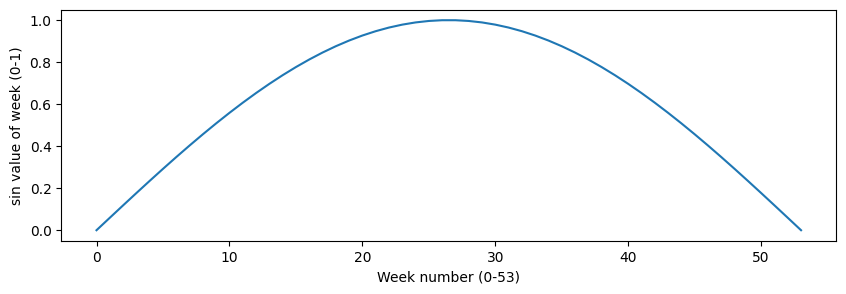

In [34]:
week = np.arange(54)
week_sin = np.sin(week* np.pi * (1/53))
plt.figure(figsize=(10,3))
plt.xlabel("Week number (0-53)")
plt.ylabel("sin value of week (0-1)")
plt.plot(week, week_sin);

In [35]:
merged_t_len = len(merged_train.columns)
merged_train.insert(merged_t_len, "Month_sin", np.sin(merged_train.Month * np.pi * (1/12)), False)
merged_train.insert(merged_t_len, "Week_sin", np.sin(merged_train.Week * np.pi * (1/53)), False)
merged_train.insert(merged_t_len, "Hour_sin", np.sin(merged_train.Hour * np.pi * (1/24)), False)
merged_train.insert(merged_t_len, "wind_direction_sin", np.sin(merged_train.wind_direction * np.pi * (1/360)), False)

merged_t_len = len(merged_test.columns)
merged_test.insert(merged_t_len, "Month_sin", np.sin(merged_test.Month * np.pi * (1/12)), False)
merged_test.insert(merged_t_len, "Week_sin", np.sin(merged_test.Week * np.pi * (1/53)), False)
merged_test.insert(merged_t_len, "Hour_sin", np.sin(merged_test.Hour * np.pi * (1/24)), False)
merged_test.insert(merged_t_len, "wind_direction_sin", np.sin(merged_test.wind_direction * np.pi * (1/360)), False)

### Now let us add some features based on date and time

If we look carefully, people use more energy in day time as compared to night time. Also, energy consumption changes based on the current weather. Thus, we can also these two features: **isDaytime** and **season**.

In [36]:
# Adding isDaytime feature
# 7<=hour<=18 represents dayTime
merged_train["isDaytime"]=0
merged_train["isDaytime"][merged_train.Hour<=18]=1
merged_train["isDaytime"][merged_train.Hour<7]=0

merged_test["isDaytime"]=0
merged_test["isDaytime"][merged_test.Hour<=18]=1
merged_test["isDaytime"][merged_test.Hour<7]=0

| Seasons    | Months | Ordinal Number |
| ---------- | ------ | -------------- |
| Spring | 3,4,5 | 2 |
| Summer | 6,7,8 | 3 |
| Fall | 9,10,11 | 0 |
| Winter | 12,1,2 | 1 |

In [37]:
merged_train['season']=1
merged_train['season'][merged_train.Month<=11]=0
merged_train['season'][merged_train.Month<=8]=3
merged_train['season'][merged_train.Month<=5]=2
merged_train['season'][merged_train.Month<=2]=1

merged_test['season']=1
merged_test['season'][merged_test.Month<=11]=0
merged_test['season'][merged_test.Month<=8]=3
merged_test['season'][merged_test.Month<=5]=2
merged_test['season'][merged_test.Month<=2]=1

In [38]:
# Now remove the existing date and time feature
merged_train.drop(["Month", "Week", "Hour", "wind_direction"], axis=1, inplace=True);
merged_test.drop(["Month", "Week", "Hour", "wind_direction"], axis=1, inplace=True);

## 2. Handling categorical feature, primary_use

### Handling year_built

In [39]:
# What about the 'year_built' column?
merged_train.year_built.unique()

array([2008., 2004., 1991., 2002., 1975., 2000., 1981., 1989., 2003.,
       2010., 1968., 1999., 2013., 1974., 1996., 1980., 1977., 1990.,
       1985., 2001., 1969., 2005., 2016., 2014., 1970., 1971., 2011.,
       1997., 2007., 1998., 2009., 1979., 1986., 2006., 1982., 1983.,
       1913., 1953., 1909., 1958., 1960., 1976., 1906., 1900., 1995.,
       1956., 1930., 1967., 1919., 1955., 1965., 1907., 2012., 1992.,
       1948., 1950., 1941., 1957., 1964., 1940., 1951., 1966., 1934.,
       1959., 1993., 1939., 1918., 1963., 1987., 1914., 1973., 1988.,
       1935., 1942., 2015., 1931., 1928., 1929., 1908., 1927., 1923.,
       1962., 1944., 1910., 1949., 2017., 1922., 1911., 1932., 1978.,
       1912., 1916., 1924., 1926., 1904., 1984., 1903., 1925., 1961.,
       1921., 1972., 1936., 1954., 1905., 1920., 1917., 1952., 1994.,
       1933., 1945., 1938., 1915., 1947., 1946., 1902., 1937.],
      dtype=float16)

In [40]:
merged_test.year_built.unique()

array([2008., 2004., 1991., 2002., 1975., 2000., 1981., 1989., 2003.,
       2010., 1968., 1999., 2013., 1974., 1996., 1980., 1977., 1990.,
       1985., 2001., 1969., 2005., 2016., 2006., 2014., 1970., 1971.,
       2011., 1997., 2007., 1998., 2009., 1979., 1986., 1982., 1983.,
       1913., 1953., 1909., 1958., 1960., 1976., 1906., 1900., 1995.,
       1956., 1930., 1967., 1919., 1955., 1965., 1907., 2012., 1992.,
       1948., 1950., 1941., 1957., 1964., 1940., 1951., 1966., 1934.,
       1959., 1993., 1939., 1918., 1963., 1987., 1914., 1973., 1988.,
       1935., 1942., 2015., 1931., 1928., 1929., 1908., 1927., 1923.,
       1962., 1944., 1910., 1949., 2017., 1922., 1911., 1932., 1978.,
       1912., 1916., 1924., 1926., 1904., 1984., 1903., 1925., 1961.,
       1921., 1972., 1936., 1954., 1905., 1920., 1917., 1952., 1994.,
       1933., 1945., 1938., 1915., 1947., 1946., 1902., 1937.],
      dtype=float16)

Definitely, year_built cannot be one-hot encoded. This is a categorical feature. We can group consecutive five years into one. e.g. 1900-1905 can grouped as 0, 1906-1910 as 1 and so on.

In [41]:
min_year_built = min(merged_train.year_built)
merged_train.year_built = ((merged_train.year_built-min_year_built)/5)

min_year_built = min(merged_test.year_built)
merged_test.year_built = ((merged_test.year_built-min_year_built)/5)

In [42]:
merged_train.year_built.unique()

array([21.6, 20.8, 18.2, 20.4, 15. , 20. , 16.2, 17.8, 20.6, 22. , 13.6,
       19.8, 22.6, 14.8, 19.2, 16. , 15.4, 18. , 17. , 20.2, 13.8, 21. ,
       23.2, 22.8, 14. , 14.2, 22.2, 19.4, 21.4, 19.6, 21.8, 15.8, 17.2,
       21.2, 16.4, 16.6,  2.6, 10.6,  1.8, 11.6, 12. , 15.2,  1.2,  0. ,
       19. , 11.2,  6. , 13.4,  3.8, 11. , 13. ,  1.4, 22.4, 18.4,  9.6,
       10. ,  8.2, 11.4, 12.8,  8. , 10.2, 13.2,  6.8, 11.8, 18.6,  7.8,
        3.6, 12.6, 17.4,  2.8, 14.6, 17.6,  7. ,  8.4, 23. ,  6.2,  5.6,
        5.8,  1.6,  5.4,  4.6, 12.4,  8.8,  2. ,  9.8, 23.4,  4.4,  2.2,
        6.4, 15.6,  2.4,  3.2,  4.8,  5.2,  0.8, 16.8,  0.6,  5. , 12.2,
        4.2, 14.4,  7.2, 10.8,  1. ,  4. ,  3.4, 10.4, 18.8,  6.6,  9. ,
        7.6,  3. ,  9.4,  9.2,  0.4,  7.4], dtype=float16)

### Handling primary use

In [43]:
merged_train.primary_use.value_counts()

primary_use
Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: count, dtype: int64

In [44]:
print("Printing median values for each primary_use\n")
primary_use_dict = {}
for i in merged_train.primary_use.unique():
    primary_use_dict.update({i:  merged_train.meter_reading[merged_train.primary_use==i].median()})
primary_use_dict = sorted(primary_use_dict.items(), key= lambda ele: ele[1]) #sorting the array based on the value of dict
primary_use_dict

Printing median values for each primary_use



[('Religious worship', 4.106500148773193),
 ('Other', 12.5),
 ('Warehouse/storage', 21.274999618530273),
 ('Retail', 25.032499313354492),
 ('Parking', 30.356000900268555),
 ('Entertainment/public assembly', 45.540000915527344),
 ('Public services', 46.0),
 ('Lodging/residential', 62.0),
 ('Office', 72.0009994506836),
 ('Manufacturing/industrial', 93.98600006103516),
 ('Services', 95.0),
 ('Food sales and service', 97.19999694824219),
 ('Technology/science', 97.25),
 ('Education', 104.33000183105469),
 ('Utility', 175.5749969482422),
 ('Healthcare', 211.85800170898438)]

Thus, primary_use also seems to be an ordinal feature based on how much each of the category consumes electricity. We can rank them based on their mean value. e.g. "Religious worship" gets the rank 1, "Other" gets rank 2 and so on.

In [45]:
merged_train['primary_use_rank'] = np.zeros(merged_train.shape[0])
merged_test['primary_use_rank'] = np.zeros(merged_test.shape[0])

for i in range(len(primary_use_dict)):
    merged_train.primary_use_rank[merged_train.primary_use==primary_use_dict[i][0]]=i
    merged_test.primary_use_rank[merged_test.primary_use==primary_use_dict[i][0]]=i

# we can now delete the primary_use row
merged_train.drop("primary_use", inplace=True, axis=1)
merged_test.drop("primary_use", inplace=True, axis=1)

merged_train.primary_use_rank = merged_train.primary_use_rank.astype(np.int8)

In [46]:
# Let us now check the dependencies of the data of our matrix
# merged_train.corr().style.background_gradient(cmap='coolwarm')

# Training a model

In [47]:
merged_train = reduce_mem_usage(merged_train)
merged_test = reduce_mem_usage(merged_test)

Memory usage of dataframe is 1388.13 MB
Memory usage after optimization is: 694.06 MB
Decreased by 50.0%
Memory usage of dataframe is 2982.44 MB
Memory usage after optimization is: 1471.34 MB
Decreased by 50.7%


# 1. RandomForestRegressor model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import pickle

In [49]:
rfr = RandomForestRegressor(n_estimators=10, #number of trees in the forest
                            n_jobs = -1, # number of processors to use
                            random_state=10) # to reproduce the same result
y_train = merged_train.meter_reading
merged_train.drop("meter_reading", axis=1, inplace=True)
rfr.fit(merged_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=10)

In [50]:
del merged_train

In [52]:
merged_test.head()

,row_id,meter,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,wind_direction_sin,Hour_sin,Week_sin,Month_sin,isDaytime,season,primary_use_rank
0,0,0,7432,21.59375,3.0,17.796875,4.0,11.703125,0.0,1021.5,3.599609,0.765625,0.000000,0.348145,0.258789,0,1,13.0
1,129,0,7432,21.59375,3.0,17.796875,2.0,12.796875,0.0,1022.0,3.099609,0.906250,0.130493,0.348145,0.258789,0,1,13.0
2,258,0,7432,21.59375,3.0,16.093750,0.0,12.796875,0.0,1022.0,3.099609,0.939453,0.258789,0.348145,0.258789,0,1,13.0
3,387,0,7432,21.59375,3.0,17.203125,0.0,13.296875,0.0,1022.0,3.099609,0.939453,0.382568,0.348145,0.258789,0,1,13.0
4,516,0,7432,21.59375,3.0,16.703125,2.0,13.296875,0.0,1022.5,2.599609,0.906250,0.500000,0.348145,0.258789,0,1,13.0


In [53]:
merged_test.sort_values(by='row_id')
merged_test.drop('row_id', inplace=True, axis=1)

In [71]:
ans = pd.DataFrame(np.array(list(range(0, len(merged_test)))), columns=['row_id'])

In [75]:
ans['meter_reading'] = np.array(rfr.predict(merged_test))

In [76]:
ans

,row_id,meter_reading
0,0,0.0000
1,1,0.0000
2,2,0.0000
3,3,0.0000
4,4,0.0000
...,...,...
41697595,41697595,4.0300
41697596,41697596,4.0550
41697597,41697597,3.4575
41697598,41697598,4.0925


In [80]:
ans.to_csv("rfr_result.csv", index=False)

## Achieved a score of 2.782 on kaggle submission for this random forest model which is not too far from the best score of 0.931 (lower is better).

# 2. KNN Model